In [20]:
import numpy as np
from tqdm import tqdm
import matplotlib.pylab as plt
from typing import Optional

In [41]:
import numpy as np

def input_checker(func):
    """
    A decorator function that checks the validity of input arguments.
    Args:
        func: The function to be decorated
    Returns:
        The decorated function
    Raises:
        AssertionError: If any of the input arguments is invalid.
    """
    def wrapper(std_: Optional[np.ndarray] = None,
                 mean_: Optional[np.ndarray] = None,
                 epsilon: Optional[float] = None,
                 k: Optional[int] = None,
                 n: Optional[int] = None,
                 alpha: Optional[float] = None):
        # Check the format of 'mean_'
        assert isinstance(mean_, (np.ndarray, list)), "invalid format of 'mean_'"
        # Check the format of 'std_'
        assert isinstance(std_, (np.ndarray, list)), "invalid format of 'std_'"
        # Check if 'k' is an integer
        assert isinstance(k, int), 'k needs to be an integer'
        # Check if 'k' is greater than 1
        assert k > 1, 'the value of k should be more than 1, {0} is given!'.format(kwargs['k'])
        # Check consistency of 'k', 'mean_', and 'std_'
        assert k == len(mean_) == len(std_), 'The length of std_, mean, and k are not consistent'
        # Check if 'epsilon' is a float
        assert isinstance(epsilon, float), 'The value of epsilon needs to be a float'
        # Check if 'epsilon' is between 0 and 1.0
        assert (epsilon >= 0) & (epsilon <= 1.0), 'The value of epsilon needs to be between 0 and 1.0'
        # Check if 'n' is an integer
        assert isinstance(n, int), 'the format of n is incorrect'
        # checking the step size
        assert isinstance(alpha, (type(None),float)), 'the format of alpha is incorrect'
        if alpha:
            assert alpha > 0 and alpha <=1.0, 'the value of alpha is out of range'
        # Call the original function with the validated arguments
        return func(std_, mean_, epsilon, k, n, alpha)
    return wrapper

In [42]:
@input_checker
class EpsilonGreedy:
    def __init__(self,
                 std_: Optional[np.ndarray] = None,
                 mean_: Optional[np.ndarray] = None,
                 epsilon: Optional[float] = None,
                 k: Optional[int] = None,
                 n: Optional[int] = None,
                 alpha: Optional[float] = None) -> None:
        """
        Epsilon-Greedy class for the bandit-k problem.

        Args:
            std_ (np.ndarray): Array of standard deviations for each arm. Defaults to None.
            mean_ (np.ndarray): Array of means for each arm. Defaults to None.
            epsilon (float): Exploration rate. Defaults to None.
            k (int): Number of arms. Defaults to None.
            n (int): Number of time steps. Defaults to None.
        """

        self.std_ = std_
        self.mean_ = mean_
        self.k = k
        self.epsilon = epsilon
        self.n = n
        self.Q = np.zeros((self.k))
        self.A = np.random.choice(range(self.k - 1))
        self.Q_hist = np.zeros((self.k, n))
        self.A_hist = np.zeros((self.n, )) * np.nan
        self.R = 0
        self.action_counter = np.zeros((self.k, ))
        if alpha:
            self.alpha = alpha
            self.weight = self.constant_step_sized
        else:
            self.weight = self.averaged
    
    def averaged(self)->float:
        return 1/self.action_counter[self.A]
    
    def constant_step_sized(self)->float:
        return self.alpha

    def reward(self, ind: int) -> float:
        """
        Returns a random reward for a given arm index.

        Args:
            ind (int): Index of the arm.

        Returns:
            float: Random reward for the arm.
        """
        return np.random.normal(loc=self.mean_[ind], scale=self.std_[ind])

    def run(self):
        """
        Runs the epsilon-greedy algorithm for the bandit-k problem.
        Returns:
            Tuple: Tuple containing the action-value history, action history, and action counter.
        """
        for i in range(self.n):
            if np.random.rand() <= self.epsilon or i == 0:
                self.A = np.random.choice(range(self.k))
            else:
                self.A = self.Q.argmax()
            self.action_counter[self.A] += 1
            self.R = self.reward(ind=self.A)
            self.Q[self.A] = self.Q[self.A] + self.weight() * (self.R - self.Q[self.A])
            self.Q_hist[:, i:i+1] = self.Q[:, None]
            self.A_hist[i] = self.A
        return self.Q_hist, self.A_hist, self.action_counter

In [43]:
mdl = EpsilonGreedy(mean_=[2,3,5,-3,-6],std_=[1,1,1,1,1],epsilon=0.1, k=5,n=500)
Q_,A_,S_ =mdl.run()

Text(0.5, 1.0, 'Epsilon_greedy for k-bandit problem')

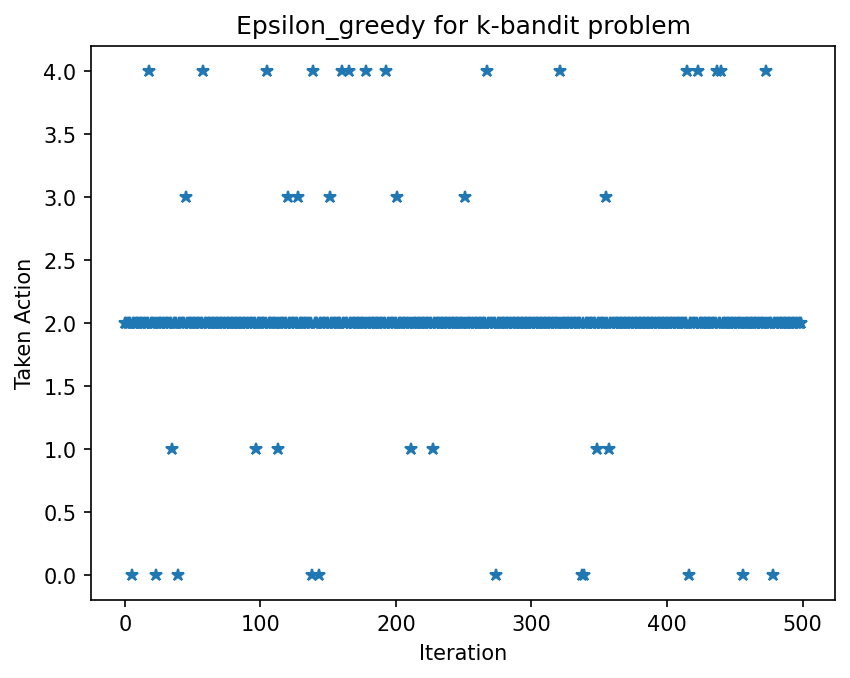

In [44]:
plt.figure(dpi=150)
plt.plot(A_,'*')
plt.xlabel('Iteration')
plt.ylabel('Taken Action')
plt.title('Epsilon_greedy for k-bandit problem')

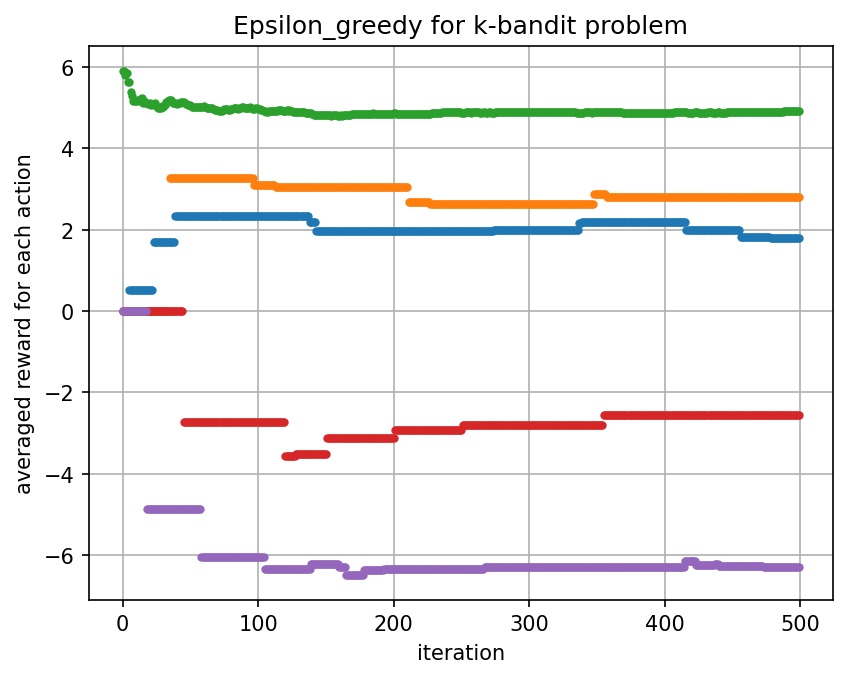

In [45]:
plt.figure(dpi=150)
plt.plot(Q_.T,'.')
plt.xlabel('iteration')
plt.ylabel('averaged reward for each action')
plt.title('Epsilon_greedy for k-bandit problem')
plt.grid(which='both')

True

In [11]:
type(None)

NoneType